In [1]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
import time
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
from sklearn.model_selection import train_test_split

from scipy.ndimage.measurements import label
%matplotlib inline


In [2]:
#Perform a Histogram of Oriented Gradients (HOG) feature extraction on 
# a labeled training set of images and train a classifier Linear SVM classifier
def get_hog_feature(img, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True):
    if vis == True:
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True,
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    else:
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features    
    
# Define a function to compute color histogram features Pass the color_space flag as 3-letter all caps string
# like 'HSV' or 'LUV' etc.
def bin_spatial(img, color_space='RGB', size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features

# Define a function to compute color histogram features 
def color_hist(img, nbins=32, bins_range=(0, 1)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

In [3]:
# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, cspace='RGB', spatial_size=(32, 32), orient=9,
                        hist_bins=32, hist_range=(0, 256),
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        # Read in each one by one
        file_features = []
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if cspace != 'RGB':
            if cspace == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif cspace == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif cspace == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif cspace == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif cspace == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)  
            
        if spatial_feat:
            # Apply bin_spatial() to get spatial color features
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        if hist_feat:
            # Apply color_hist() also with a color space option now
            hist_features = color_hist(feature_image, nbins=hist_bins, bins_range=hist_range)
            file_features.append(hist_features)
        if hog_feat == True:
        # Call get_hog_feature() with vis=False, feature_vec=True
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_feature(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)        
            else:
                hog_features = get_hog_feature(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            file_features.append(hog_features)
            
        # Append the new feature vector to the features list
        features.append(np.concatenate(file_features))    
    # Return list of feature vectors
    return features


car number is 8792
non-vehicle number is 8968
(1548, 469)


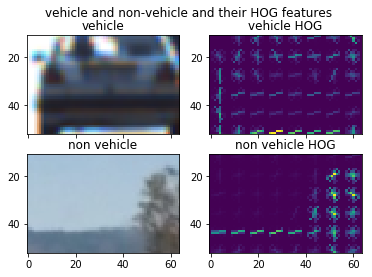

In [4]:
v_imgs = glob.glob('/mnt/data_0/Udacity/vehicles/**/*.png')
nv_imgs = glob.glob('/mnt/data_0/Udacity/non-vehicles/**/*.png')
print("car number is {}".format(len(v_imgs)))
print("non-vehicle number is {}".format(len(nv_imgs)))

v_idx = np.random.randint(0, len(v_imgs))
nv_idx = np.random.randint(0, len(nv_imgs))

print(v_idx, nv_idx)

# plot one vehicle img and hog_feature img
v_img = mpimg.imread(v_imgs[v_idx])
v_feaure, v_hog = get_hog_feature(v_img[:, :, 2], 9, 8, 8, vis=True, feature_vec=True)
nv_img = mpimg.imread(nv_imgs[nv_idx])
nv_feaure, nv_hog = get_hog_feature(nv_img[:, :, 2], 9, 8, 8, vis=True, feature_vec=True)

f, axarr = plt.subplots(2, 2, sharex=True)
f.suptitle('vehicle and non-vehicle and their HOG features')
axarr[0, 0].imshow(v_img)
axarr[0, 0].set_title('vehicle')
axarr[0, 1].imshow(v_hog)
axarr[0, 1].set_title('vehicle HOG')
axarr[1, 0].imshow(nv_img)
axarr[1, 0].set_title('non vehicle')
axarr[1, 1].imshow(nv_hog)
axarr[1, 1].set_title('non vehicle HOG')
f.savefig('imgandhog.png')

In [5]:
# Feature extraction parameters
colorspace = 'YUV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb

# Define HOG parameters
orient = 9
pix_per_cell = 8
cell_per_block = 2
hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"
spatial_size = (32, 32) # Spatial binning dimensions
hist_bins = 32    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off

v_features = extract_features(v_imgs, cspace=colorspace, orient=orient, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        hog_channel=hog_channel)
print("v_features finished")

v_features finished


In [6]:
nv_features = extract_features(nv_imgs, cspace=colorspace, orient=orient, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        hog_channel=hog_channel)
print("nv_features finished")

nv_features finished


In [7]:
# Create an array stack of feature vectors
X = np.vstack((v_features, nv_features)).astype(np.float64)    
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)
# Define the labels vector
y = np.hstack((np.ones(len(v_features)), np.zeros(len(nv_features))))
# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)

print('Using spatial binning of:',spatial_size,
    'and', hist_bins,'histogram bins', colorspace, 'cspace', hog_channel, 'hog_channel')
print('Feature vector length:', len(X_train[0]))

('Using spatial binning of:', (32, 32), 'and', 32, 'histogram bins', 'YUV', 'cspace', 'ALL', 'hog_channel')
('Feature vector length:', 8460)


In [8]:
# Use a linear SVC 
svc = LinearSVC(C=0.001)
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()
n_predict = 10
print('My SVC predicts: ', svc.predict(X_test[0:n_predict]))
print('For these',n_predict, 'labels: ', y_test[0:n_predict])
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')

(7.45, 'Seconds to train SVC...')
('Test Accuracy of SVC = ', 0.9887)
('My SVC predicts: ', array([ 0.,  1.,  1.,  0.,  1.,  0.,  1.,  1.,  0.,  0.]))
('For these', 10, 'labels: ', array([ 0.,  1.,  1.,  0.,  1.,  0.,  1.,  1.,  0.,  0.]))
(0.00175, 'Seconds to predict', 10, 'labels with SVC')


In [9]:
# Define a function to extract features from a single image window
# This function is very similar to extract_features()
# just for a single image rather than list of images
def single_img_features(img, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):    
    #1) Define an empty list to receive features
    img_features = []
    #2) Apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)      
    #3) Compute spatial features if flag is set
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        #4) Append features to list
        img_features.append(spatial_features)
    #5) Compute histogram features if flag is set
    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins)
        #6) Append features to list
        img_features.append(hist_features)
    #7) Compute HOG features if flag is set
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.extend(get_hog_feature(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))      
        else:
            hog_features = get_hog_feature(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        #8) Append features to list
        img_features.append(hog_features)

    #9) Return concatenated array of features
    return np.concatenate(img_features)


## Define a function that takes an image,
# start and stop positions in both x and y, 
# window size (x and y dimensions),  
# and overlap fraction (for both x and y)
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))

    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    draw_img = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(draw_img, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return draw_img

# Define a function you will pass an image 
# and the list of windows to be searched (output of slide_windows())
def search_windows(img, windows, clf, scaler, color_space='RGB', 
                    spatial_size=(32, 32), hist_bins=32, 
                    hist_range=(0, 256), orient=9, 
                    pix_per_cell=8, cell_per_block=2, 
                    hog_channel=0, spatial_feat=True, 
                    hist_feat=True, hog_feat=True):

    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
        #4) Extract features for that window using single_img_features()
        features = single_img_features(test_img, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
        #5) Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        #6) Predict using your classifier
        prediction = clf.predict(test_features)
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
    #8) Return windows for positive detections
    return on_windows


In [10]:
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes
    
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

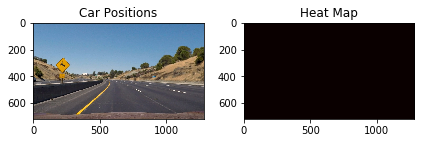

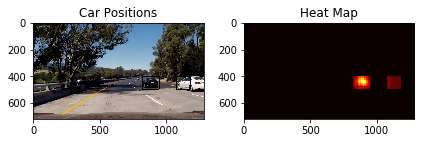

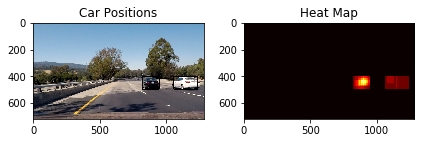

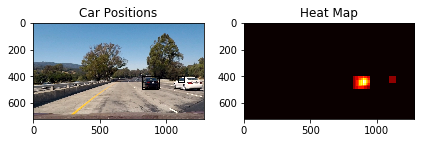

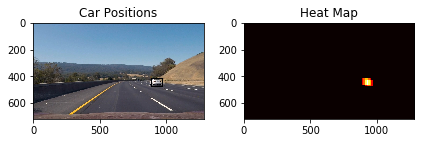

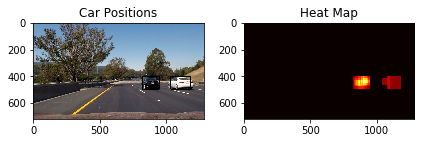

In [11]:
window_configs = [
  {
    "x_start_stop": [None, None],
    "y_start_stop": [400, 656],
    "xy_window": (256, 256),
    "xy_overlap": (0.6, 0.6)
  },
  {
    "x_start_stop": [None, None],
    "y_start_stop": [400, 656],
    "xy_window": (128, 128),
    "xy_overlap": (0.6, 0.6)
  },
  {
    "x_start_stop": [100, 1280],
    "y_start_stop": [400, 500],
    "xy_window": (96, 96),
    "xy_overlap": (0.7, 0.7)
  },
  {
    "x_start_stop": [500, 1280],
    "y_start_stop": [400, 500],
    "xy_window": (48, 48),
    "xy_overlap": (0.7, 0.7)
  }
]

def find_cars_single_scale(image):
    image = image.astype(np.float32)/255
    draw_image = np.copy(image)

    heat = np.zeros_like(image[:,:,0]).astype(np.float)
  
    all_windows = []
  
    for window_config in window_configs: 
        x_start_stop = window_config.get('x_start_stop')
        y_start_stop = window_config.get('y_start_stop')
        xy_window = window_config.get('xy_window')
        xy_overlap = window_config.get('xy_overlap')
      
        windows = slide_window(image, x_start_stop=x_start_stop, y_start_stop=y_start_stop, 
                      xy_window=xy_window, xy_overlap=xy_overlap)

        hot_windows = search_windows(image, windows, svc, X_scaler, color_space=colorspace, 
                          spatial_size=spatial_size, hist_bins=hist_bins, 
                          orient=orient, pix_per_cell=pix_per_cell, 
                          cell_per_block=cell_per_block, 
                          hog_channel=hog_channel, spatial_feat=spatial_feat, 
                          hist_feat=hist_feat, hog_feat=hog_feat)   
    
        for window in hot_windows:
            all_windows.append(window)
  
    # Add heat to each box in box list
    heat = add_heat(heat,all_windows)

    # Apply threshold to help remove false positives
    heat = apply_threshold(heat,1)

    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)

    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    draw_image = draw_labeled_bboxes(draw_image, labels)
  
    return draw_image, heatmap

idx = 1
for img_name in glob.glob('./test_images/*.jpg'):# Show single image result
    image = mpimg.imread(img_name)
    draw_img, heatmap = find_cars_single_scale(image);
    fig = plt.figure()
    plt.subplot(121)
    plt.imshow(draw_img)
    plt.title('Car Positions')
    plt.subplot(122)
    plt.imshow(heatmap, cmap='hot')
    plt.title('Heat Map')
    fig.tight_layout()
    plt.savefig('heatmap_C=0.001_{}.png'.format(idx))
    idx += 1

In [20]:
from collections import deque
history = deque(maxlen=8)

class Video(object):
  
    def __init__(self):
        self.frame_count = 0
        self.last_labels = None

    def update(self):
        self.frame_count += 1
        
        
def process_video(img):
    video.update()
    image = img
    image = image.astype(np.float32)/255
    draw_image = np.copy(img)

    if video.frame_count == 1 or video.frame_count % 5 == 0:
        heat = np.zeros_like(image[:,:,0]).astype(np.float)
        all_windows = []

        for window_config in window_configs:
            x_start_stop = window_config.get('x_start_stop')
            y_start_stop = window_config.get('y_start_stop')
            xy_window = window_config.get('xy_window')
            xy_overlap = window_config.get('xy_overlap')

            windows = slide_window(image, x_start_stop=x_start_stop, y_start_stop=y_start_stop, 
                        xy_window=xy_window, xy_overlap=xy_overlap)

            hot_windows = search_windows(image, windows, svc, X_scaler, color_space=colorspace, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)   
        
            for window in hot_windows:
                all_windows.append(window)

        heat = add_heat(heat,all_windows)
        
        #---deque----------
        current_heatmap = np.clip(heat, 0, 255)
        history.append(current_heatmap)
        heatmap = np.zeros_like(current_heatmap).astype(np.float)
        for heat in history:
            heatmap = heatmap + heat
        
        threshold = 6
        heatmap = apply_threshold(heatmap, threshold)
        #---end of deque---  
        labels = label(heatmap)
        video.last_labels = labels
        draw_image = draw_labeled_bboxes(draw_image, labels)  
    else:
        draw_image = draw_labeled_bboxes(draw_image, video.last_labels)
        
    return draw_image

In [19]:
from moviepy.editor import VideoFileClip

video = Video()
output = 'result_history.mp4'
clip1 = VideoFileClip("./project_video.mp4")
clip = clip1.fl_image(process_video)
%time clip.write_videofile(output, audio=False)

[MoviePy] >>>> Building video result_history_6.mp4
[MoviePy] Writing video result_history_6.mp4


100%|█████████▉| 1260/1261 [06:00<00:00,  3.50it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: result_history_6.mp4 

CPU times: user 5min 56s, sys: 4.72 s, total: 6min 1s
Wall time: 6min
